# Poincare Boundary Condition

Most of the tutorials use last closed flux surface (LCFS) as the boundary condition for 3D equilibrium. This tutorial will cover another way to define boundary condition using DESC.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines. 

In [2]:
# from desc import set_device
# set_device("gpu")

Import required stuff.

In [3]:
%matplotlib inline
import numpy as np

from desc.objectives import (
    ObjectiveFunction,
    ForceBalance,
    get_fixed_xsection_constraints,
    get_fixed_boundary_constraints,
)
from desc.examples import get
from desc.optimize import Optimizer
from desc.plotting import plot_comparison, plot_section
from desc.geometry import ZernikeRZLToroidalSection
from desc.equilibrium import Equilibrium

DESC version 0.12.1+1376.g5c7fb3123.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 9.63 GB available memory


### Solving Poincare Boundary Condition from an existing equilibrium

To first show that Poincare BC gives the same result with LCFS, let's set our optimization problem by taking the $\zeta$=0 Poincare cross-section of Heliotron equilibrium.

In [4]:
def set_poincare_equilibrium(eq, zeta=0):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=zeta),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

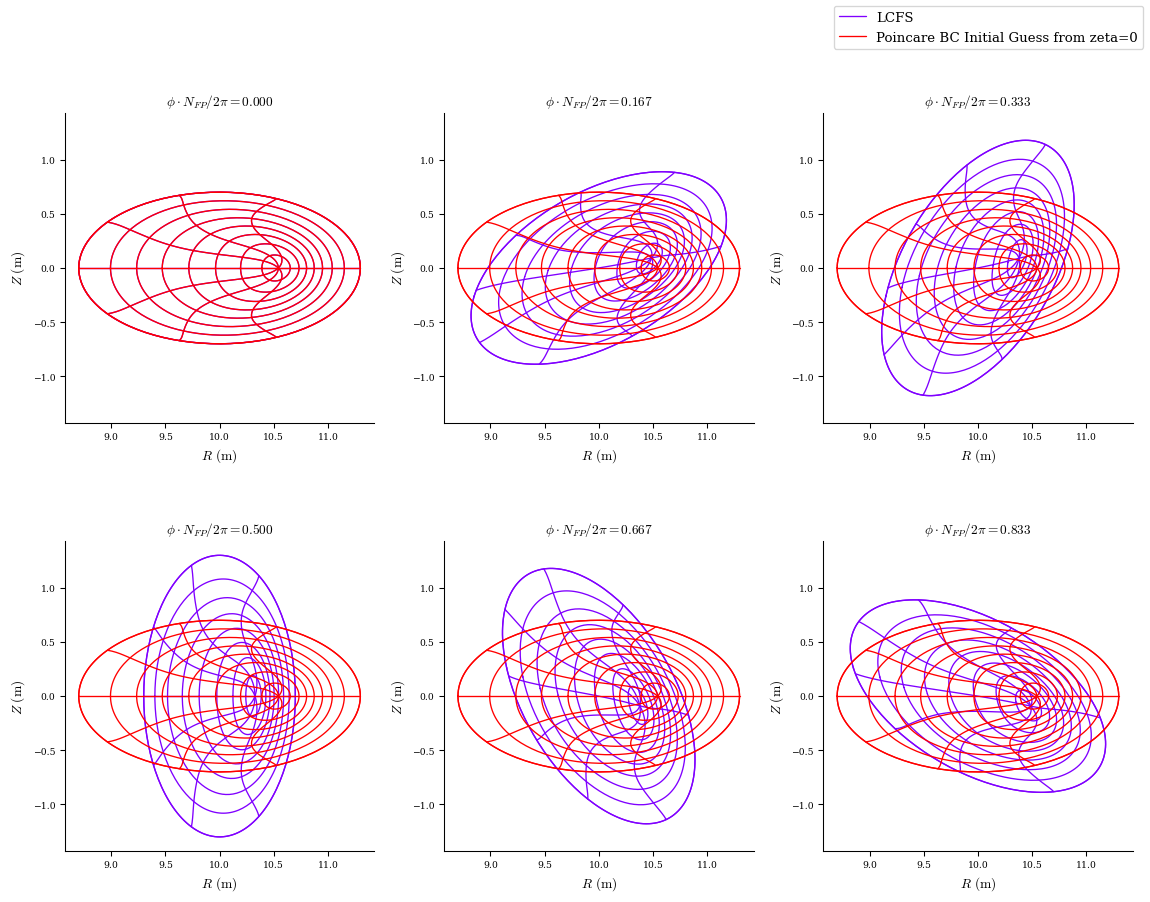

In [5]:
eq = get("HELIOTRON")
zeta = 0
eq_poin = set_poincare_equilibrium(eq, zeta=zeta)
plot_comparison(
    eqs=[eq, eq_poin], labels=["LCFS", f"Poincare BC Initial Guess from zeta=0"]
);

We can also choose $\zeta = \pi$ as the boundary condition and set it from an existing equilibrium.

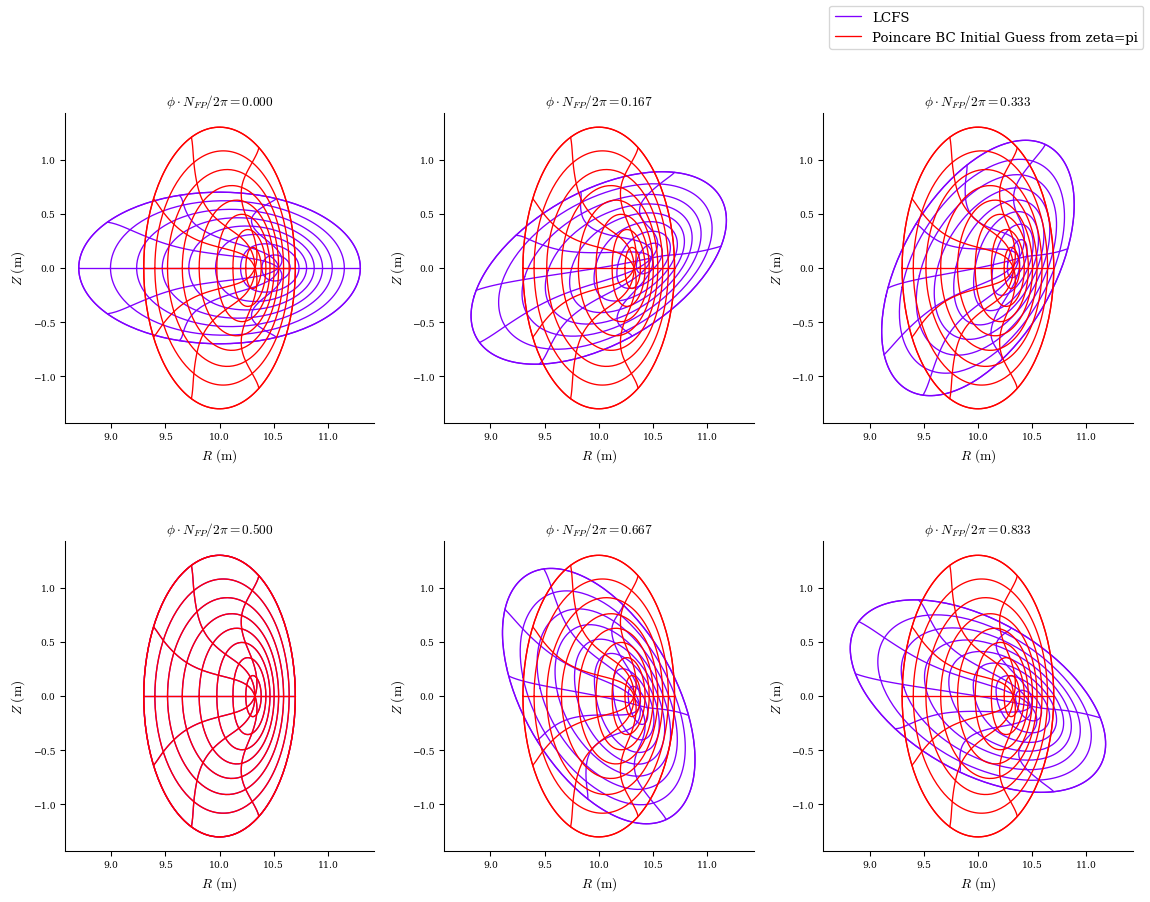

In [6]:
zeta = np.pi / eq.NFP
eq_poin = set_poincare_equilibrium(eq, zeta=zeta)
plot_comparison(
    eqs=[eq, eq_poin], labels=["LCFS", "Poincare BC Initial Guess from zeta=pi"]
);

Now, we can solve the newly created 'eq_poin' as usual. The code will apply some checks to see if you are trying to solve a Poincare BC problem or LCFS. Then, add the required constraints and objectives before sending it to the optimizer.

In [7]:
eq_poin = set_poincare_equilibrium(eq)  # the default zeta value is 0
eq_poin.change_resolution(N=1, N_grid=2)

constraints = get_fixed_xsection_constraints(eq=eq_poin)
objective = ObjectiveFunction(ForceBalance(eq_poin))
optimizer = Optimizer("lsq-exact")

eq_poin.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    maxiter=100,
)

eq_poin.change_resolution(N=eq.N, N_grid=2 * eq.N)

constraints = get_fixed_xsection_constraints(eq=eq_poin)
objective = ObjectiveFunction(ForceBalance(eq_poin))
optimizer = Optimizer("lsq-exact")

eq_poin.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    maxiter=100,
)
plot_comparison(eqs=[eq, eq_poin], labels=["LCFS", f"Poincare BC"]);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 1.42 sec
Timer: Objective build = 2.84 sec
Building objective: poincare R
Building objective: poincare Z
Building objective: fixed Psi
Building objective: poincare Lambda
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency boundary R
Building objective: self_consistency boundary Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section Lambda
Timer: Objective build = 2.52 sec
Timer: Linear constraint projection build = 9.81 sec
Number of parameters: 507
Number of objectives: 1900
Timer: Initializing the optimization = 15.2 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost   

(Equilibrium at 0x7c0389b8d250 (L=24, M=12, N=1, NFP=19, sym=True, spectral_indexing=fringe),
     message: Maximum number of iterations has been exceeded.
     success: False
         fun: [ 7.458e-07 -1.200e-04 ... -1.187e-03 -1.011e-03]
           x: [-2.556e-03  2.008e-03 ... -3.550e-02  1.010e+00]
         nit: 5
        cost: 0.13006731053658516
           v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
  optimality: 74.13723747316797
        nfev: 9
        njev: 6
        allx: [Array([-1.339e-16,  1.242e-17, ...,  7.272e-15, -4.441e-16],      dtype=float64), Array([ 4.029e-03,  7.355e-04, ..., -6.572e-04, -3.983e-03],      dtype=float64), Array([ 8.251e-03,  9.014e-04, ..., -5.631e-04, -8.379e-03],      dtype=float64), Array([ 1.708e-02,  2.471e-03, ...,  8.987e-05, -1.787e-02],      dtype=float64), Array([ 3.496e-02,  6.507e-03, ..., -1.740e-03, -3.122e-02],      dtype=float64), Array([ 6.673e-02,  1.720e-02, ..., -3.547e-03, -4.344e-02],      dtype=float64)]
       allt

In [ ]:
eq = get("HELIOTRON")
eq_fixed = Equilibrium(
    surface=eq.surface,
    pressure=eq.pressure,
    iota=eq.iota,
    Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
    NFP=eq.NFP,  # number of field periods
    L=eq.L,  # radial spectral resolution
    M=eq.M,  # poloidal spectral resolution
    N=eq.N,  # toroidal spectral resolution
    L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
    M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
    N_grid=eq.N_grid,  # real space toroidal resolution
    sym=eq.sym,  # explicitly enforce stellarator symmetry
    spectral_indexing=eq._spectral_indexing,
)
constraints = get_fixed_boundary_constraints(eq=eq_fixed)
objective = ObjectiveFunction(ForceBalance(eq_fixed))
optimizer = Optimizer("lsq-exact")

eq_fixed.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    maxiter=200,
)
plot_comparison(eqs=[eq, eq_fixed], labels=["LCFS", "LCFS resolve"]);

In [ ]:
plot_section(eq, "|F|", norm_F=True, log=True)
plot_section(eq_poin, "|F|", norm_F=True, log=True);

In [ ]:
f1 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq_poin.compute("<|F|>_vol")["<|F|>_vol"]
    / eq_poin.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error eq: {f1:.4e}")
print(f"Force error eq_poin: {f2:.4e}")

### Creating a new Poincare surface to fix 

We can also create a new surface object called "ZernikeRZLToroidalSection" to set our optimization problem as LCFS.

In [ ]:
R_lmn = np.array([10, -1.2, -0.2, 0.1])
modes_R = np.array([[0, 0], [1, 1], [2, 0], [2, 2]])

Z_lmn = np.array([0.7, -0.04, -0.02])
modes_Z = np.array([[1, -1], [2, -2], [3, -3]])

L_lmn = np.array([0.1])
modes_L = np.array([[1, -1]])

section = ZernikeRZLToroidalSection(
    R_lmn=R_lmn,
    modes_R=modes_R,
    Z_lmn=Z_lmn,
    modes_Z=modes_Z,
    L_lmn=L_lmn,
    modes_L=modes_L,
)

eq_poincare = Equilibrium(
    xsection=section,
    pressure=0,
    iota=0,
    Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
    NFP=10,  # number of field periods
    L=5,  # radial spectral resolution
    M=5,  # poloidal spectral resolution
    N=4,  # toroidal spectral resolution
    L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
    M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
    N_grid=eq.N_grid,  # real space toroidal resolution
    sym=True,  # explicitly enforce stellarator symmetry
    spectral_indexing=eq._spectral_indexing,
)

plot_comparison(eqs=[eq_poincare], labels=["Poincare Surface"]);